#FashionMNIST

In [1]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

from sklearn.metrics import classification_report

import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Device 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


#전처리(Transform 적절히 변경)

In [3]:
#Transform 설정(preprocessing 설정)
transform = transforms.Compose([
    transforms.Resize(224), #이미지 resoulution 변경
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load FashionMNIST
train_data  = dsets.FashionMNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)
test_data = dsets.FashionMNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

100%|██████████| 26.4M/26.4M [00:03<00:00, 8.64MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 170kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.14MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 17.5MB/s]


In [4]:
batch_size = 64 # 배치 크기

train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(test_data,
                         batch_size=batch_size,
                         shuffle=False)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot') #각각 0~9에 해당


#데이터셋 미리보기

In [5]:
def imshow(img, title):
    img = torchvision.utils.make_grid(img, normalize=True)
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

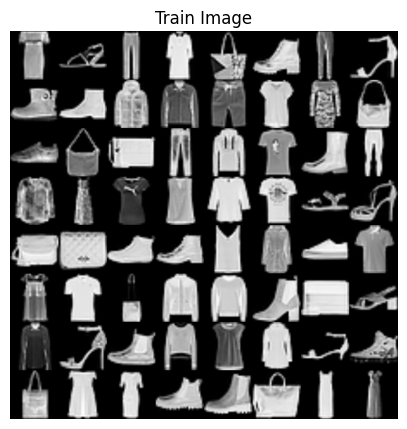

In [6]:
train_iter = iter(train_loader)
images, labels = next(train_iter) # Use next(train_iter) instead of train_iter.next()

imshow(images, "Train Image")

In [7]:
images.shape

torch.Size([64, 1, 224, 224])

#CNN 모델

In [8]:
import torch.nn.init as init

#MBConv 블록 정의(기본 단위, inverted Residual Bottleneck 구조 사용 + SE는 모델 간소화를 위해 생략)

In [13]:
#EfficientNet 구조 참고함.
class MBConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expansion):
        super(MBConv, self).__init__()
        self.use_residual = (in_channels == out_channels) and (stride == 1)  # 채널의 모양이 같고 stride가 1이면 residual 연결 (Skip connection 이용(ResNet))
        hidden_dim = in_channels * expansion  # 확장 후의 채널 수

        #Inverted residual 구조(MobileNet v2에서 처음으로 도입)
        # 1x1 확장 컨볼루션 (expansion이 1이면 생략, 채널수를 증가 시킴)
        self.expand = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim, kernel_size=1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.SiLU() #Relu 대신 SiLU 사용(x * sigmoid)
        ) if expansion != 1 else nn.Identity()

        # 3x3 depthwise 컨볼루션(각 채널별로 한개의 필터 연산 적용, 연산량 감소 효과)
        self.depthwise = nn.Sequential(
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1, groups=hidden_dim, bias=False), #(in_channel == groups 인 경우를 depthwise 연산이리 힘)
            nn.BatchNorm2d(hidden_dim),
            nn.SiLU()
        )

        # 원래는 SE 구조가 들어갈 위치(모델 간소화를 위해 생략)

        # 1x1 project 컨볼루션 (채널을 원하는 개수로 축소)
        self.project = nn.Sequential(
            nn.Conv2d(hidden_dim, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        identity = x  # residual 연결용 입력 보존(skip connection 연산 수행을 위해 저장)
        out = self.expand(x)
        out = self.depthwise(out)
        out = self.project(out)
        # residual 연결 여부에 따라 skip connection을 수행하거나 수행하지 않음
        if self.use_residual:
            return identity + out # skip connection 수행
        else:
            return out

#Model 정의


In [14]:
class CNN(nn.Module):
    def __init__(self, num_classes=10, width_coefficient=1.0, depth_coefficient=1.0):
        super(CNN, self).__init__()

        # 채널 수를 너비 계수에 따라 조정하는 함수
        def round_filters(filters, width_coefficient, divisor=8, min_depth=8):
            if not width_coefficient:
                return filters
            filters *= width_coefficient
            new_filters = max(min_depth, int(filters + divisor / 2) // divisor * divisor)  # 8의 배수로 조정
            if new_filters < 0.9 * filters:
                new_filters += divisor  # 너무 많이 줄어드는 것 방지
            return int(new_filters)

        # 반복 횟수를 깊이 계수에 따라 조정하는 함수
        def round_repeats(repeats, depth_coefficient):
            return int(np.ceil(repeats * depth_coefficient))

        # stem: 네트워크의 입력부
        base_channels = 32  # stem 출력 채널 기본값
        final_channels = round_filters(1280, width_coefficient)  # 마지막 head conv 채널 수
        stem_out = round_filters(base_channels, width_coefficient)  # 너비 확장된 stem 출력 채널 수

        # 입력 이미지 (1채널: FashionMNIST) → stem_out 채널
        self.stem = nn.Sequential(
            nn.Conv2d(1, stem_out, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(stem_out),
            nn.SiLU()  # 활성화 함수 (SiLU = x * sigmoid(x))
        )

        # EfficientNet 구조 이용: (출력 채널 수, 반복 횟수, stride, expansion 비율)
        settings = [
            (16, 1, 1, 1),   # Stage 1
            (24, 2, 2, 6),   # Stage 2
            (40, 2, 2, 6),   # Stage 3
            (80, 3, 2, 6),   # Stage 4
            (112, 3, 1, 6),  # Stage 5
            (192, 4, 2, 6),  # Stage 6
            (320, 1, 1, 6)   # Stage 7
        ]

        blocks = []
        in_channels = stem_out  # 첫 블록의 입력은 stem의 출력 채널 수

        for out_c, repeats, stride, expansion in settings:
            out_channels = round_filters(out_c, width_coefficient)  # 너비 계수 반영
            num_repeats = round_repeats(repeats, depth_coefficient)  # 깊이 계수 반영

            # 첫 블록은 주어진 stride로 구성
            blocks.append(MBConv(in_channels, out_channels, stride=stride, expansion=expansion))
            in_channels = out_channels  # 이후 반복을 위한 입력 채널 업데이트

            # 나머지 반복은 stride = 1
            for _ in range(1, num_repeats):
                blocks.append(MBConv(in_channels, out_channels, stride=1, expansion=expansion))

        self.blocks = nn.Sequential(*blocks)  # 모든 MBConv 블록 연결

        # Head 부분: 마지막 conv → 평균 풀링 → FC
        self.head = nn.Sequential(
            nn.Conv2d(in_channels, final_channels, kernel_size=1, bias=False),  # 채널 확장
            nn.BatchNorm2d(final_channels),
            nn.SiLU(),
            nn.AdaptiveAvgPool2d(1),  # 전체 공간 평균 (Global Average Pooling)
            nn.Flatten(),             # 1D 벡터로 변환
            nn.Dropout(0.2),          # 과적합 방지
            nn.Linear(final_channels, num_classes)  # 최종 분류기
        )

    def forward(self, x):
        x = self.stem(x)    # 입력 계층 (초기 conv)
        x = self.blocks(x)  # EfficientNet 블록 반복
        x = self.head(x)    # 출력 계층
        return x


#Train

Epoch [1/5], Iter [93/938], Loss: 0.7937, Acc: 60.79%
Epoch [1/5], Iter [186/938], Loss: 0.4644, Acc: 70.22%
Epoch [1/5], Iter [279/938], Loss: 0.6544, Acc: 74.37%
Epoch [1/5], Iter [372/938], Loss: 0.3802, Acc: 77.21%
Epoch [1/5], Iter [465/938], Loss: 0.1768, Acc: 79.20%
Epoch [1/5], Iter [558/938], Loss: 0.4488, Acc: 80.64%
Epoch [1/5], Iter [651/938], Loss: 0.3437, Acc: 81.65%
Epoch [1/5], Iter [744/938], Loss: 0.5394, Acc: 82.65%
Epoch [1/5], Iter [837/938], Loss: 0.3457, Acc: 83.37%
Epoch [1/5], Iter [930/938], Loss: 0.3679, Acc: 84.03%
Epoch [1/5], Iter [938/938], Loss: 0.2599, Acc: 84.08%
Epoch [1] Learning Rate: 0.000271
Epoch [2/5], Iter [93/938], Loss: 0.2920, Acc: 92.19%
Epoch [2/5], Iter [186/938], Loss: 0.2383, Acc: 92.09%
Epoch [2/5], Iter [279/938], Loss: 0.2610, Acc: 92.03%
Epoch [2/5], Iter [372/938], Loss: 0.2785, Acc: 91.92%
Epoch [2/5], Iter [465/938], Loss: 0.1862, Acc: 91.85%
Epoch [2/5], Iter [558/938], Loss: 0.0963, Acc: 91.79%
Epoch [2/5], Iter [651/938], Loss

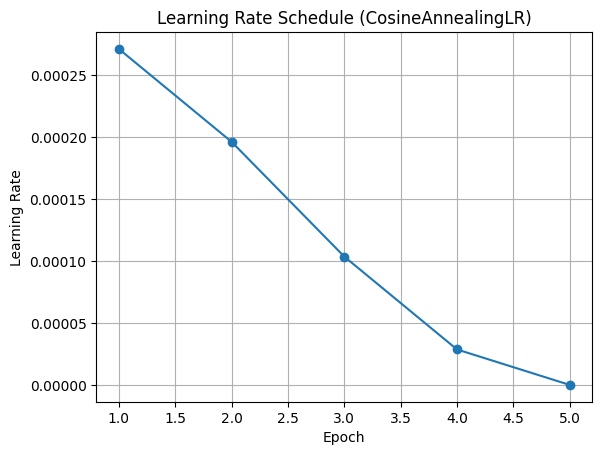

In [15]:
# 학습 전 매개변수들 설정
model = CNN(width_coefficient=1.0, depth_coefficient=1.0).to(device)  # 모델 초기화 및 GPU 할당
criterion = nn.CrossEntropyLoss()  # 다중 클래스 분류 손실 함수

# AdamW 옵티마이저 사용, learning rate는 3e-4로 설정
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

# CosineAnnealingLR 스케줄러 설정: 전체 에폭 수에 걸쳐 코사인 형태로 학습률 감소
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)

num_epochs = 5
total_batch = len(train_loader)  # 전체 배치 수

# 학습률 기록용 리스트
lr_history = []

# 학습 시작
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (batch_images, batch_labels) in enumerate(train_loader):
        X = batch_images.to(device)
        Y = batch_labels.to(device)

        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += Y.size(0)
        correct += (predicted == Y).sum().item()

        # 10%마다 결과 출력
        if (i + 1) % (total_batch // 10) == 0 or (i + 1) == total_batch:
            print('Epoch [%d/%d], Iter [%d/%d], Loss: %.4f, Acc: %.2f%%' %
                  (epoch + 1, num_epochs, i + 1, total_batch, loss.item(), 100 * correct / total))

    scheduler.step()  # 에폭 종료 후 학습률 업데이트

    # 현재 학습률 저장 및 출력
    current_lr = scheduler.get_last_lr()[0]
    lr_history.append(current_lr)
    print(f"Epoch [{epoch + 1}] Learning Rate: {current_lr:.6f}")

# 학습률 그래프 시각화
plt.plot(range(1, num_epochs + 1), lr_history, marker='o')
plt.title('Learning Rate Schedule (CosineAnnealingLR)')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

# Model 저장

In [16]:
# 모델 저장
model_save_path = "mycnn_fashionmnist.pth"
torch.save(model.state_dict(), model_save_path)
print(f"모델이 저장되었습니다: {model_save_path}")

# 모델 불러오기 (필요시)
# model = CNN(num_classes=10, width_coefficient=1.0, depth_coefficient=1.0)
# model.load_state_dict(torch.load(model_save_path))
# model.to(device)


모델이 저장되었습니다: mycnn_fashionmnist.pth


#Evaluate

In [17]:
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_data.classes))


Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.88      0.87      0.88      1000
     Trouser       1.00      0.99      0.99      1000
    Pullover       0.90      0.91      0.91      1000
       Dress       0.93      0.92      0.92      1000
        Coat       0.88      0.92      0.90      1000
      Sandal       0.99      0.99      0.99      1000
       Shirt       0.79      0.78      0.78      1000
     Sneaker       0.96      0.98      0.97      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.98      0.97      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



#시각화

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

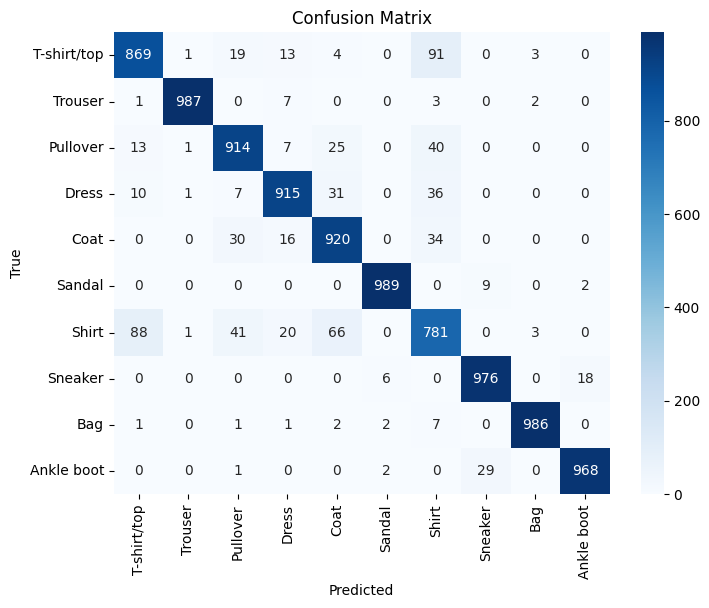

In [20]:
# 혼동 행렬 시각화 코드
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# y_true, y_pred, classes는 이전 셀에서 정의된 변수입니다.
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import numpy as np

# 1) 클래스별 정확도 계산
num_classes = len(classes)
class_correct = np.zeros(num_classes, dtype=int)
class_total   = np.zeros(num_classes, dtype=int)

for t, p in zip(y_true, y_pred):
    class_total[t] += 1
    if t == p:
        class_correct[t] += 1

class_acc = class_correct / class_total

# 2) 대표 이미지 추출 (de-normalize 포함)
rep_images = [None] * num_classes
with torch.no_grad():
    for images, labels in test_loader:
        for img, lbl in zip(images, labels):
            lbl = lbl.item()
            if rep_images[lbl] is None:
                # de-normalize: img * 0.5 + 0.5
                img_cpu = img.cpu() * 0.5 + 0.5
                rep_images[lbl] = img_cpu
        if all(x is not None for x in rep_images):
            break


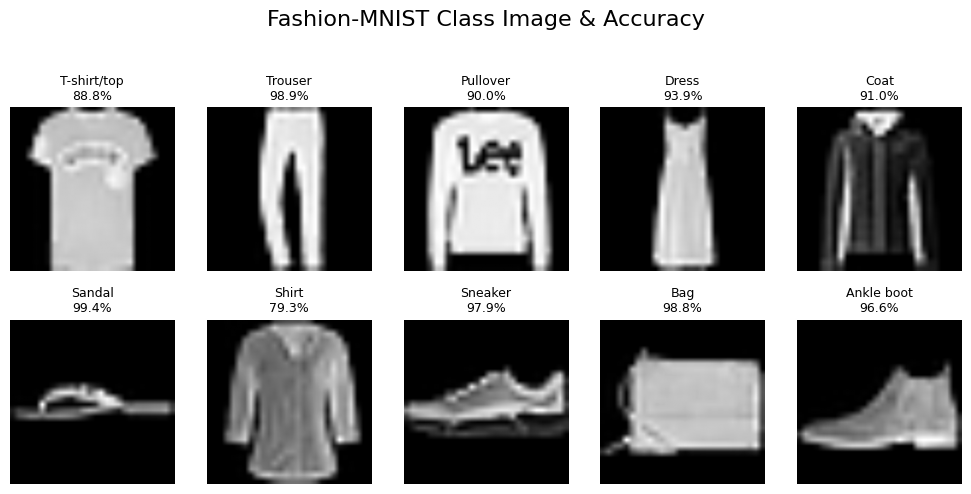

In [ ]:
import matplotlib.pyplot as plt

# 2행 5열로 서브플롯 생성
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
fig.suptitle('Fashion-MNIST Class Image & Accuracy', fontsize=16)

# 행 간격(hspace) 조정
fig.subplots_adjust(hspace=0.9)

# axes를 1차원 배열로 평탄화
axes = axes.flatten()
for i, ax in enumerate(axes[:num_classes]):
    # 이미지 표시
    ax.imshow(rep_images[i].squeeze(), cmap='gray')
    ax.axis('off')
    # 클래스명과 정확도 타이틀에 함께 표시
    acc_pct = class_acc[i] * 100
    ax.set_title(f"{classes[i]}\n{acc_pct:.1f}%", fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
